In [1]:
import os
import time
import math
from functools import partial
from functools import wraps
from typing import Callable
from typing import NamedTuple
from typing import ParamSpec
from typing import TypeVar


import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets

In [2]:
torch.manual_seed(246)

DIR_NAME = os.getcwd()

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 20
LR = 0.1

# DNN parameters
INPUT_SIZE = 28*28
NUM_HIDDEN_NEURONS = 300
NUM_CLASSES = 10

In [3]:
class MNIST(datasets.MNIST):
    def __getitem__(self, index: int) -> tuple[Tensor, int]:
        img, target = self.data[index], int(self.targets[index])

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


def transform(data: Tensor) -> Tensor:
    return torch.flatten(data / 255).to(torch.float32)


def one_hot_encode(class_index: int, num_classes: int) -> Tensor:
    one_hot = torch.zeros((num_classes), dtype=torch.float32)
    one_hot[class_index] = 1.0

    return one_hot

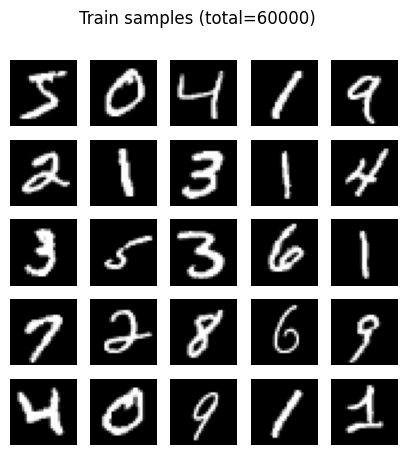

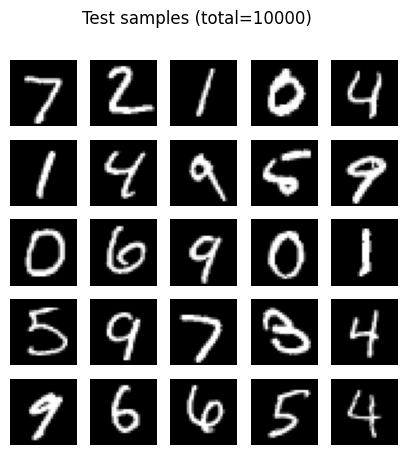

In [4]:
def show_images(images: Tensor, title: str, nx: int = 5, ny: int = 5) -> None:
    fig, axes = plt.subplots(ny, nx, figsize=(nx, ny))
    fig.suptitle(title)

    for index, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(images[index], cmap='gray')


one_hot = partial(one_hot_encode, num_classes=NUM_CLASSES)
dataset = partial(
    MNIST,
    root=DIR_NAME,
    download=True,
    transform=transform,
    target_transform=one_hot,
)
train_dataset = dataset(train=True)
test_dataset = dataset(train=False)

show_images(train_dataset.data, f'Train samples (total={len(train_dataset)})')
show_images(test_dataset.data, f'Test samples (total={len(test_dataset)})')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
class Weights(NamedTuple):
    w1: Tensor
    b1: Tensor
    w2: Tensor
    b2: Tensor


class ForwardResult(NamedTuple):
    z1: Tensor
    a1: Tensor
    z2: Tensor
    a2: Tensor


class BackwardResult(NamedTuple):
    dw1: Tensor
    db1: Tensor
    dw2: Tensor
    db2: Tensor

In [6]:
def relu(x: Tensor) -> Tensor:
    return torch.max(torch.zeros_like(x), x)


def relu_derivative(x: Tensor) -> Tensor:
    return (x > 0).to(torch.float32)


def softmax(x: Tensor, dim=1) -> Tensor:
    exp = torch.exp(x)
    return exp / torch.sum(exp, dim=dim, keepdim=True)


def xavier(*size: int) -> tuple[Tensor, Tensor]:
    def _scale(x: Tensor, a: float, b: float) -> Tensor:
        return a + x * (b - a)

    c = math.sqrt(6) / math.sqrt(sum(size))
    scale = partial(_scale, a=-c, b=c)
    rand_w = torch.rand(*size, dtype=torch.float32)
    rand_b = torch.rand(1, size[-1], dtype=torch.float32)

    return scale(rand_w), scale(rand_b)


def accuracy(predictions: Tensor, ground_truth: Tensor) -> float:
    return float(
        (predictions.argmax(dim=1) == ground_truth.argmax(dim=1))
        .to(torch.int8)
        .sum()
        / len(ground_truth)
    )

In [7]:
class DNN(object):
    def __init__(
            self,
            in_features: int = 28*28,
            out_features: int = 10,
            hidden_neurons: int = 300,
            *,
            lr: float,
    ) -> None:
        self.lr = lr

        self._no_grad = False
        self._weights = Weights(
            *xavier(in_features, hidden_neurons),
            *xavier(hidden_neurons, out_features),
        )

    @property
    def no_grad(self) -> bool:
        return self._no_grad

    @no_grad.setter
    def no_grad(self, no_grad: bool) -> None:
        self._no_grad = no_grad

    def _forward(self, x: Tensor) -> ForwardResult:
        z1 = x @ self._weights.w1 + self._weights.b1
        a1 = relu(z1)
        z2 = a1 @ self._weights.w2 + self._weights.b2
        a2 = softmax(z2)

        return ForwardResult(z1, a1, z2, a2)

    def _backward(
            self,
            data: Tensor,
            forward_result: ForwardResult,
            ground_truth: Tensor,
    ) -> BackwardResult:
        m, *__ = data.shape
        dz2 = forward_result.a2 - ground_truth
        dw2 = forward_result.a1.T @ dz2 / m
        db2 = torch.sum(dz2) / m

        dz1 = dz2 @ self._weights.w2.T * relu_derivative(forward_result.z1)
        dw1 = data.T @ dz1 / m
        db1 = torch.sum(dz1) / m

        return BackwardResult(dw1, db1, dw2, db2)

    def _update_weights(self, backward_result: BackwardResult) -> None:
        w1 = self._weights.w1 - self.lr * backward_result.dw1
        b1 = self._weights.b1 - self.lr * backward_result.db1
        w2 = self._weights.w2 - self.lr * backward_result.dw2
        b2 = self._weights.b2 - self.lr * backward_result.db2

        self._weights = Weights(w1, b1, w2, b2)

    def __call__(self, data: Tensor, ground_truth: Tensor) -> Tensor:
        forward_result = self._forward(data)

        if not self._no_grad:
            backward_result = self._backward(data, forward_result, ground_truth)
            self._update_weights(backward_result)

        return forward_result.a2

In [8]:
_P = ParamSpec("_P")
_T = TypeVar("_T")


def timeit(func: Callable[_P, _T]) -> Callable[_P, tuple[_T, float]]:
    @wraps(func)
    def _wrapper(*args: _P.args, **kwargs: _P.kwargs) -> tuple[_T, float]:
        start = time.monotonic()
        result = func(*args, **kwargs)
        stop = time.monotonic()

        return result, stop - start
    return _wrapper

In [9]:
@timeit
def run_epoch(dnn: DNN, dataloader: DataLoader) -> tuple[Tensor, Tensor]:
    prediction_batches: list[Tensor] = []
    ground_truth_batches: list[Tensor] = []

    for x_batch, y_batch in dataloader:
        prediction = dnn(x_batch, y_batch)
        prediction_batches.append(prediction)
        ground_truth_batches.append(y_batch)

    prediction = torch.concat(prediction_batches)
    ground_truth = torch.concat(ground_truth_batches)

    return prediction, ground_truth

In [10]:
dnn = DNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN_NEURONS, lr=LR)
dnn.no_grad = False

print("Training...")

training_time = 0

for epoch in range(1, NUM_EPOCHS + 1):
    (prediction, ground_truth), epoch_time = run_epoch(dnn, train_dataloader)
    training_time += epoch_time
    print(
        f"Epoch: {epoch:02d} "
        f"| Accuracy: {accuracy(prediction, ground_truth):.4f} "
        f"| Time: {epoch_time:.4f}s"
    )

print(f"Training time: {training_time:.4f}s")
print("\nTesting...")

dnn.no_grad = True
(prediction, ground_truth), epoch_time = run_epoch(dnn, test_dataloader)
print(f"Accuracy: {accuracy(prediction, ground_truth):.4f} | Time: {epoch_time:.4f}")

Training...
Epoch: 01 | Accuracy: 0.8994 | Time: 1.6560s
Epoch: 02 | Accuracy: 0.9448 | Time: 1.6560s
Epoch: 03 | Accuracy: 0.9596 | Time: 1.6570s
Epoch: 04 | Accuracy: 0.9678 | Time: 1.6870s
Epoch: 05 | Accuracy: 0.9738 | Time: 1.6560s
Epoch: 06 | Accuracy: 0.9772 | Time: 1.6560s
Epoch: 07 | Accuracy: 0.9808 | Time: 1.6720s
Epoch: 08 | Accuracy: 0.9828 | Time: 1.7500s
Epoch: 09 | Accuracy: 0.9851 | Time: 1.7030s
Epoch: 10 | Accuracy: 0.9870 | Time: 1.6880s
Epoch: 11 | Accuracy: 0.9884 | Time: 1.6720s
Epoch: 12 | Accuracy: 0.9898 | Time: 1.7180s
Epoch: 13 | Accuracy: 0.9910 | Time: 1.7190s
Epoch: 14 | Accuracy: 0.9920 | Time: 1.7030s
Epoch: 15 | Accuracy: 0.9930 | Time: 1.7340s
Epoch: 16 | Accuracy: 0.9937 | Time: 1.7030s
Epoch: 17 | Accuracy: 0.9946 | Time: 1.7190s
Epoch: 18 | Accuracy: 0.9954 | Time: 1.6090s
Epoch: 19 | Accuracy: 0.9963 | Time: 1.6100s
Epoch: 20 | Accuracy: 0.9966 | Time: 1.6870s
Training time: 33.6550s

Testing...
Accuracy: 0.9809 | Time: 0.2190
